In [ ]:
# importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from scipy import stats
%matplotlib inline
from numpy import array

In [ ]:
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# connecting to the google drive to get the file for input
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# getting required attribute from the data
attr = 'category'
df = pd.read_csv('drive/MyDrive/publaynet/data.csv', encoding='utf-8').fillna(0)

df=df[attr]
#dividing the data into train and test data
train_size = int(len(df)*0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
raw_seq = np.array(train_data)
# choose a number of time steps
n_steps = 3
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)

In [ ]:
raw_seq = np.array(test_data)
# choose a number of time steps
n_steps = 3
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data

In [ ]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (96605, 3)
y_train.shape:  (96605,)
X_test.shape:  (24150, 3)
y_test.shape:  (24150,)


In [ ]:
# Creating LSTM model 
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units=units, activation='relu', input_shape=(3, 1)))
    # Hidden layer
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='mse')
    return model
model_lstm = create_lstm(50)

In [ ]:
# Creating GRU model 
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = (3,1)))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 2)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(50)

In [ ]:
# Fitting the model 
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop], verbose = False)
    return history
history_gru = fit_model(model_gru)
history_lstm = fit_model(model_lstm)

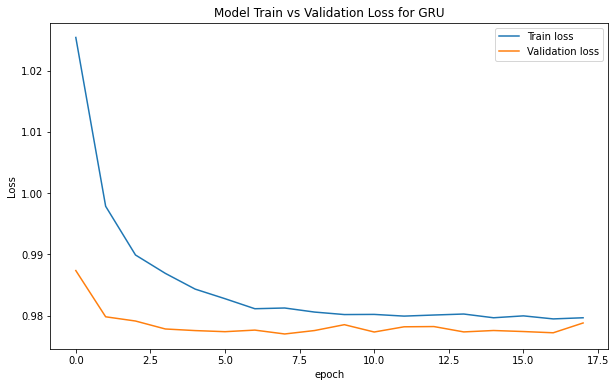

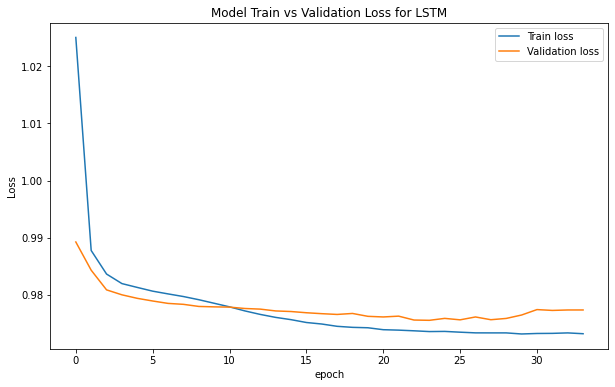

In [ ]:
# Plotting the loss graphs 
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_lstm, 'LSTM')

In [ ]:
# predicting on test data using the model
def prediction(model):
    prediction = model.predict(X_test)
    return prediction
prediction_gru = prediction(model_gru)
prediction_lstm = prediction(model_lstm)

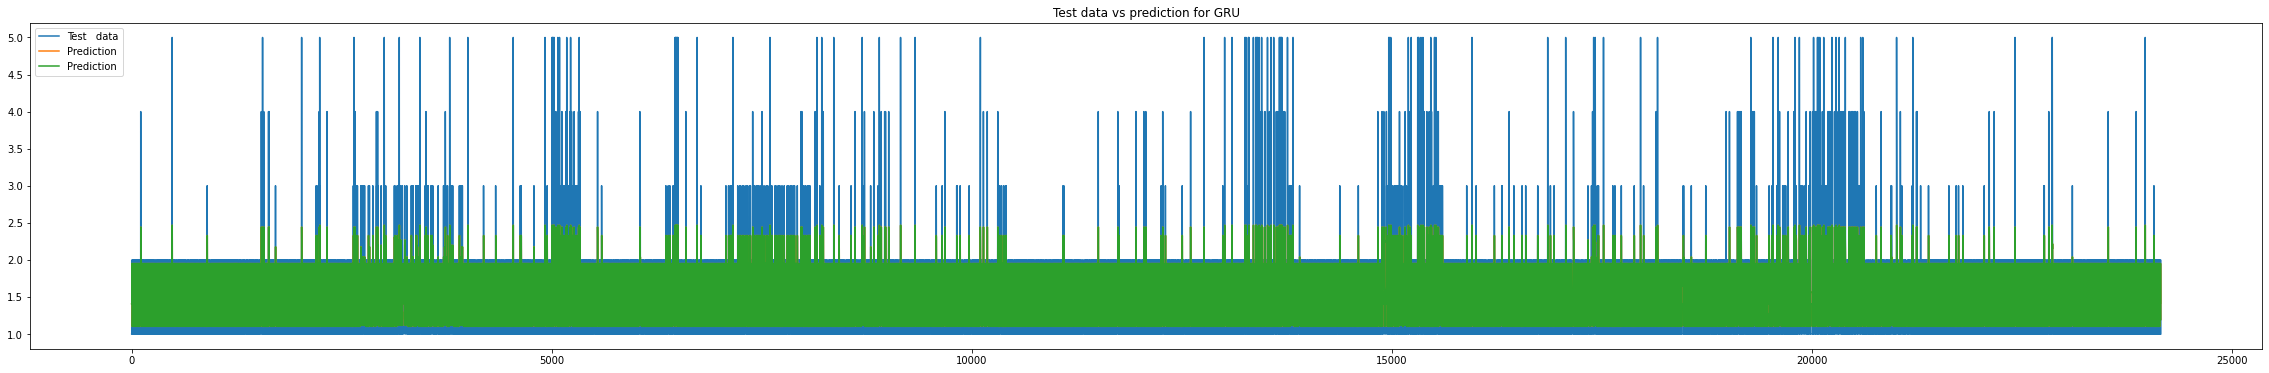

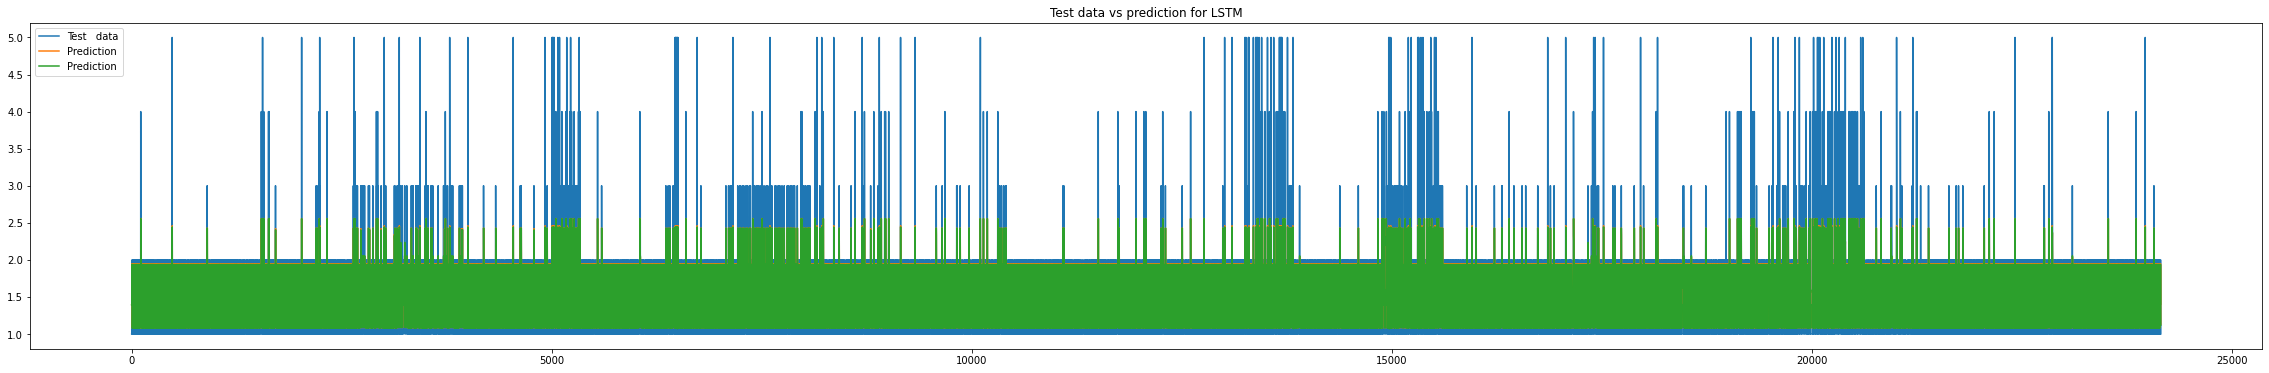

In [ ]:
# Plotting the predicted vs actual data
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(40, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')

 
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)

In [ ]:
# getting the scores for the models 
def eval(model, model_name):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(model_name + ':')
    print('Scores: {:.4f}'.format(scores))
eval(model_gru,  'GRU')
eval(model_lstm, 'LSTM')

GRU:
Scores: 0.3023
LSTM:
Scores: 0.2991
